In [34]:
## Import the necessary library and functions



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

[nltk_data] Downloading package punkt to C:\Users\KAZIM
[nltk_data]     BEKTAS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\KAZIM
[nltk_data]     BEKTAS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\KAZIM
[nltk_data]     BEKTAS\AppData\Roaming\nltk_data...


### Business Problem : Kozmos, which focuses on home textiles and daily wear products sold through Amazon, aims to increase sales by analyzing product reviews and improving product features based on complaints. 

### Purpose : Sentiment Analysis will be performed on the reviews, and the data will be labeled. A classification model will then be created using the labeled data.

### Dataset Story

#### The dataset consists of reviews for a specific product group, containing variables such as the review title, star rating, the number of people who found the review helpful, and the review content itself.

Here is the description of the variables: The dataset contains 4 variables and 5611 observations, with a file size of 489 KB.

- **Star**: The star rating given to the product.
- **HelpFull**: The number of people who found the review helpful.
- **Title**: A short title or heading for the review.
- **Review**: The actual content of the review.

In [4]:
## Load the dataset

df = pd.read_excel("amazon.xlsx")

df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


#### DATA EXPLORATION

In [13]:
## Lets check dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5611 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [14]:
## Statistical summary of the dataset.

df.describe()

,Star,HelpFul
count,5611.00,5611.00
mean,4.41,0.98
std,1.17,4.11
min,1.00,0.00
25%,4.00,0.00
50%,5.00,0.00
75%,5.00,1.00
max,5.00,124.00


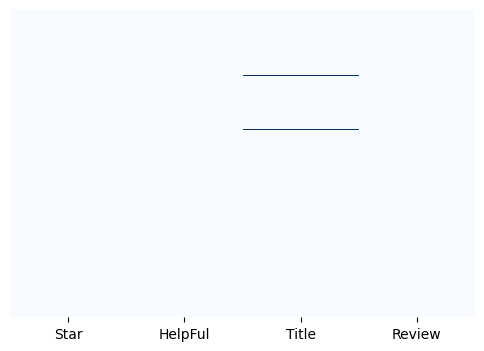

In [18]:
## Check missing value in the dataset by creating heatmap

plt.figure(figsize=(6, 4))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")
plt.show()

<Axes: xlabel='Star', ylabel='count'>

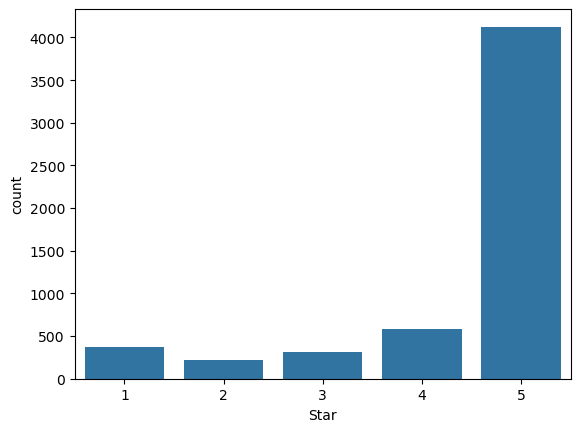

In [19]:
# Plot the count plot for the star

sns.countplot(x = df['Star']) 

#### TEXT PRE-PROCESSING

In [ ]:
## Perform the following operations on the "Review" variable:
### a. Convert all letters to lowercase
### b. Remove punctuation marks
### c. Remove numerical expressions from the reviews
### d. Remove stopwords (words that do not carry meaningful information) from the data
### e. Remove words that appear less than 1,000 times in the data
### f. Apply lemmatization

In [5]:
# Normalizing Case Folding

df['Review'] = df['Review'].str.lower()

In [6]:
# Remove Punctuations

df['Review'] = df['Review'].str.replace('[^\w\s]', '')

In [7]:
# Remove numerical expressions

df['Review'] = df['Review'].str.replace('\d', '')

In [8]:
# Remove Stopwords

sw = stopwords.words('english')

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))


In [9]:
# Rarewords less than 1000

rarewords = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in rarewords))

In [11]:
# Lemmatization

df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['Review'].head(10)

0                                                happy
1     good quality material however panel mis-matched.
2    product fun bedroom windows.<br />imagery bit ...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck can't believe quality material...
5                                 look different photo
6    exactly looking for. heavy material. great pri...
7    looking picture, thought curtain would thinner...
8    much whiter thought would wasn’t really expect...
9    curtain picture shows. 3rd set ambesonne curta...
Name: Review, dtype: object

#### Text Visualization

In [12]:
## Barplot

#### Step 1: Barplot Visualization Process
####  a. Calculate the word frequencies in the "Review" variable and store them as tf.
####  b. Rename the columns of the tf DataFrame as "words" and "tf".
####  c. Filter the words where the "tf" value is greater than 500 and visualize them using a bar plot.

In [24]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [25]:
tf

,index,0
0,happy,171.00
1,good,453.00
2,quality,609.00
3,material,398.00
4,however,36.00
...,...,...
9207,crisp.<br,1.00
9208,wfh,1.00
9209,provided.,1.00
9210,gamers,1.00


In [26]:
# Rename the columns of the tf DataFrame as "words" and "tf".

tf.columns = ["words", "tf"]
tf

,words,tf
0,happy,171.00
1,good,453.00
2,quality,609.00
3,material,398.00
4,however,36.00
...,...,...
9207,crisp.<br,1.00
9208,wfh,1.00
9209,provided.,1.00
9210,gamers,1.00


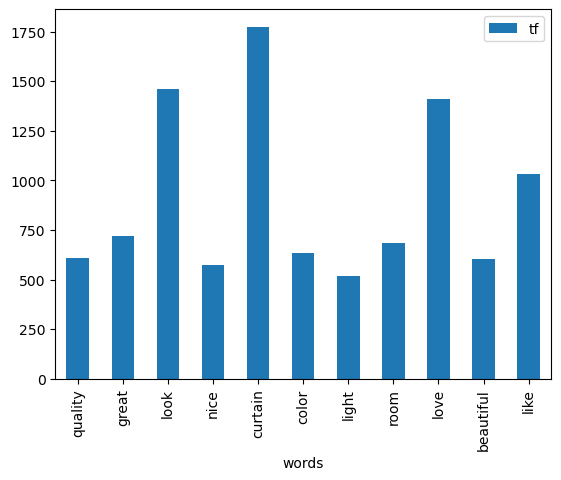

In [27]:
# Filter the words where the "tf" value is greater than 500 and visualize them using a bar plot.

tf[tf["tf"] > 500].plot.bar(x="words", y="tf")

plt.show()

#### Plot The WordCloud

In [28]:
## STEPS

## a. Store all words from the "Review" variable as a string named "text".
## b. Define and save the WordCloud template shape.
## c. Generate the saved WordCloud using the string created in the first step.
## d. Complete the visualization steps (figure, imshow, axis, show).

In [29]:
# Store all words from the "Review" variable as a string named "text".

text = " ".join(i for i in df.Review)

In [30]:
## Define and save the WordCloud template shape.

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)

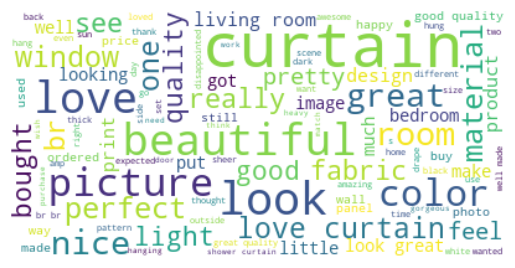

In [31]:
##  Complete the visualization

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Sentiment Analysis

In [35]:
df["Review"].head()

0                                                happy
1     good quality material however panel mis-matched.
2    product fun bedroom windows.<br />imagery bit ...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck can't believe quality material...
Name: Review, dtype: object

In [36]:
# Creating a SentimentIntensityAnalyzer object.

sia = SentimentIntensityAnalyzer()

In [37]:
# Calculate polarity_scores() for the first 10 observations of the "Review" variable.

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.537, 'pos': 0.463, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp...
7    {'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [38]:
# Filter and re-examine the first 10 observations based on their compound scores.

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.93
8   0.00
9   0.71
Name: Review, dtype: float64

In [39]:
## Update the compound scores for the 10 observations: If the compound score is greater than 0, label it as "pos". Otherwise, label it as "neg".

df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [40]:
## Assign pos-neg labels for all observations in the "Review" variable based on their compound scores and add them as a new column in the DataFrame.

df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [41]:
df.head()

,Star,HelpFul,Title,Review,Sentiment_Label
0,5,0,looks great,happy,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel mis-matched.,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windows.<br />imagery bit ...,pos
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,neg
4,5,0,Wow great purchase,great bang buck can't believe quality material...,pos


In [42]:
df["Sentiment_Label"].value_counts()

Sentiment_Label
pos    4793
neg     818
Name: count, dtype: int64

In [43]:
df.groupby("Sentiment_Label")["Star"].mean()

Sentiment_Label
neg   3.45
pos   4.57
Name: Star, dtype: float64

##### **By labeling the reviews with SentimentIntensityAnalyzer, the dependent variable for the comment classification machine learning model has been created.**

##### PREPEARING MODEL

In [44]:
# Identify the dependent and independent variables, and then split the data into train and test sets.

# random_state for getting for same results

# Test-Train
train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["Sentiment_Label"],
                                                    random_state=42)

##### TF-IDF WORD VECTORIZATION (TOKENIZATION)

In [45]:
# Create a TfidfVectorizer object. Fit the object on the train data    

tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)

# Transform both the train and test

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)

x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

#### MODELLING

##### 1) Logistic Regression

In [46]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

In [47]:
# Predict the test data using the predict function and save the predictions.

y_pred = log_model.predict(x_test_tf_idf_word)

In [48]:
#  Report the prediction results using classification_report to evaluate performance.

print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

         neg       0.32      0.97      0.48        73
         pos       1.00      0.89      0.94      1330

    accuracy                           0.89      1403
   macro avg       0.66      0.93      0.71      1403
weighted avg       0.96      0.89      0.91      1403



In [49]:
# Use cross-validation to calculate the average accuracy score.

cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()

0.8538891713268937

#####  Randomly Selecting Reviews and Making Predictions

In [50]:
# Randomly selecting a sample from the "Review" variable:

random_review = pd.Series(df["Review"].sample(1).values)

In [51]:
#  Vectorizing the sample using CountVectorizer:

new_review = CountVectorizer().fit(train_x).transform(random_review)

In [52]:
# Making a prediction with the model

pred = log_model.predict(new_review)

In [53]:
# Printing the sample and the prediction result

print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  received curtain today. disappointed. color like picture look faded dull . worth price. 
 Prediction: ['pos']


##### 2) Random Forests

In [69]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)

In [70]:
# # Use cross-validation to calculate the average accuracy score.

cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.8966471784443314

In [74]:
sample_review = pd.Series(df["Review"].sample(n=1).values)

sample_review_vectorized = CountVectorizer().fit(train_x).transform(sample_review)

In [75]:
# Making a prediction with the model

pred = rf_model.predict(sample_review_vectorized)

In [76]:
# Printing the sample and the prediction result

print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  received curtain today. disappointed. color like picture look faded dull . worth price. 
 Prediction: ['pos']


In [77]:
sample_review = pd.Series(df["Review"].sample(2).values)

print("Sample Review: ", sample_review)


Sample Review:  0    living room dinning area face other...totally ...
1                                          value money
dtype: object


In [78]:
sample_review_vectorized = CountVectorizer().fit(train_x).transform(sample_review)

In [79]:
# Predict the sentiment using the RandomForest model

prediction = rf_model.predict(sample_review_vectorized)

In [80]:
# Output the sample review and its predicted sentiment

print(f"Sample Review: {sample_review}")

# Printing the sample and the prediction result

print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Sample Review: 0    living room dinning area face other...totally ...
1                                          value money
dtype: object
Review:  received curtain today. disappointed. color like picture look faded dull . worth price. 
 Prediction: ['pos']


## Visualization of positive and negative Reviews depend on Sentiment Label

<Axes: xlabel='Sentiment_Label', ylabel='count'>

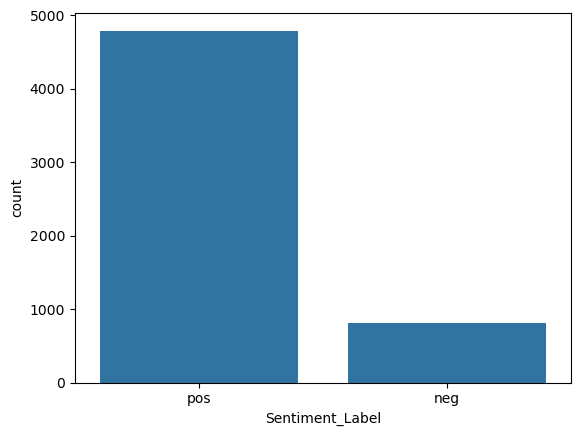

In [94]:
# Plot the count plot for the ratings

sns.countplot(x = df['Sentiment_Label'])

In [84]:
# Obtain only the positive reviews
positive = df[df['Sentiment_Label'] == "pos"]

positive

,Star,HelpFul,Title,Review,Sentiment_Label
0,5,0,looks great,happy,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel mis-matched.,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windows.<br />imagery bit ...,pos
4,5,0,Wow great purchase,great bang buck can't believe quality material...,pos
6,5,0,Perfect for spa room,exactly looking for. heavy material. great pri...,pos
...,...,...,...,...,...
5605,5,0,My daughter loves these,long ( floor curtain rod ) cover short window ...,pos
5606,4,0,Recommend,great product reasonable money. delivered quic...,pos
5608,5,0,Extremely pleasing,great studio complement entire theme area. pho...,pos
5609,5,0,Perfect,brought beauty kid room. love it.,pos


In [85]:
# Obtain only the positive reviews
negative = df[df['Sentiment_Label'] == "neg"]

negative

,Star,HelpFul,Title,Review,Sentiment_Label
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,neg
5,5,0,Not for us,look different photo,neg
8,4,0,Not what expected,much whiter thought would wasn’t really expect...,neg
10,5,0,The best Christmas decoration I think I have e...,block view living room front door kitchen/dini...,neg
11,4,0,The door images are crooked and rustic. Messes...,private closed. darkening point.,neg
...,...,...,...,...,...
5586,4,0,Beautiful curtains,one pair package. needed two pairs.,neg
5587,5,0,I wish I never purchased these curtains,vendor originally sent wrong size curtain. rec...,neg
5597,5,0,"They were beautiful, but way too long for my h...","tall ceilings, you!",neg
5600,4,0,Amazing quality,exactly described made high quality material!,neg


In [86]:
## Purpose : Combine all positive reviews and create one string

sentences = positive['Review'].tolist()
len(sentences)

4793

In [87]:
# Join all reviews into one large string

sentences_as_one_string =" ".join(sentences)

sentences_as_one_string

'happy good quality material however panel mis-matched. product fun bedroom windows.<br />imagery bit stretched, still fun.<br />material lightweight sheer, appreciate. great bang buck can\'t believe quality material. vibrant colors. eclectic style work beautifully tie together me. exactly looking for. heavy material. great price ship fast. looking picture, thought curtain would thinner sheer. nice thickness/ weight help insulate front window. look absolutely perfect!! arrived quickly. pleased purchase!! curtain picture shows. 3rd set ambesonne curtains. one set use spring summer, one autumn set christmas/ winter. durable color vibrant. recommend curtains. love curtain!! printed polyester type material, back material white. put large sliding glass door see curtain would hang. material good weight hang well. happen go outside (at night) see print outlined side curtain (just unexpected surprise). 3d quality curtain much fun. elegant. love hem one smaller one second time writing review am

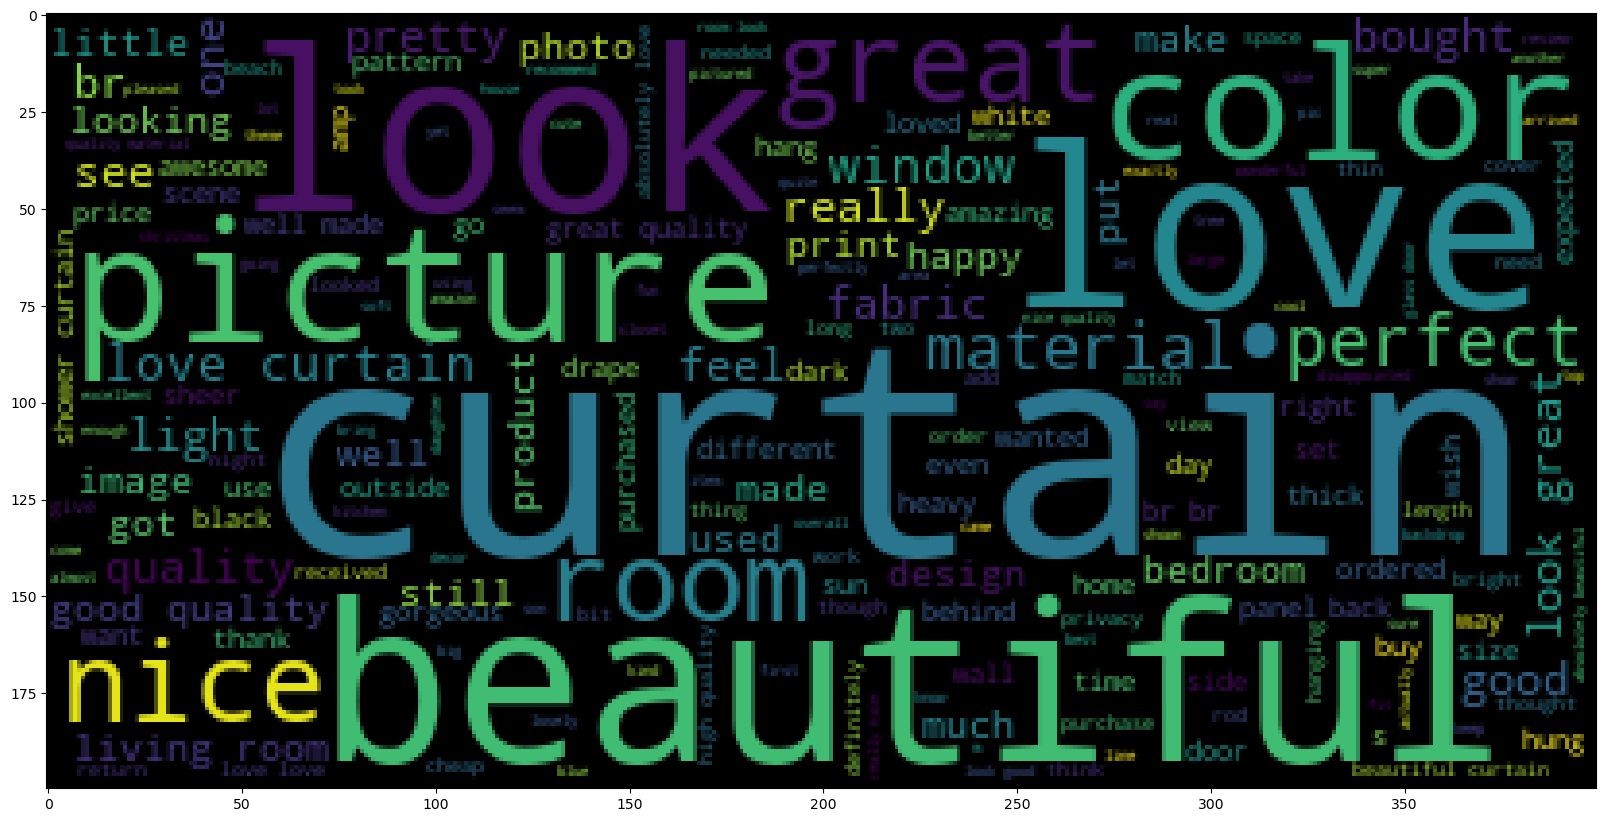

In [88]:
## Create a wordCloud 

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))

In [89]:
## Purpose : Combine all positive reviews and create one string

negative_sentences = negative['Review'].tolist()

len(negative_sentences)

818

In [92]:
# Join all reviews into one large string

negative_sentences_as_one_string =" ".join(negative_sentences)

negative_sentences_as_one_string

'lo unico que gustaria e que sean un poco ma largas look different photo much whiter thought would wasn’t really expecting wanting. use block view living room front door kitchen/dining area stress dish mess easily seen visitors. put christmas light around it, really brightens everything up. private closed. darkening point. don’t block light work fine night curtain sheer daytime labeled darkening curtain fault ordering them.  live coastal town across ocean....so ocean view..lovin used cover open cabinet area room. material solids. keep mind screen little dark. used one panel returned advertise. actual image nearly clear line photo is. lake / pond hard see somewhat disappointing cost. ordered curtain mistake intended return decided hang adult son\'s room lark ordered use room divider rod block open space behind couch. put black curtain side fill space didn\'t. couch front them, look good. dislike lined, light room behind - tell. now, way really look bad, would give 5 star lined. unique w

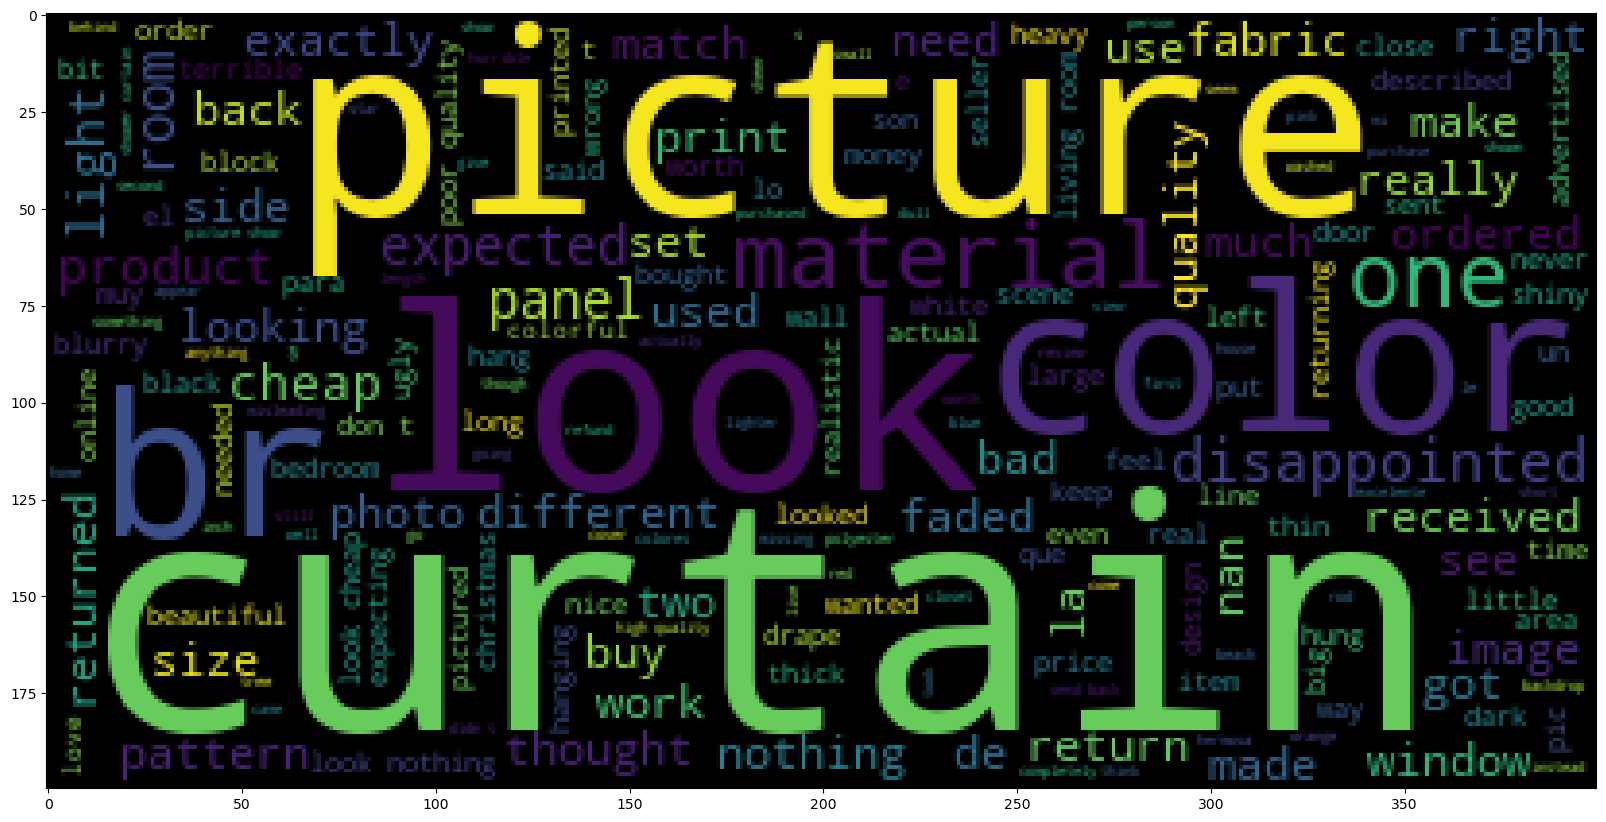

In [93]:
plt.figure(figsize = (20,20))

plt.imshow(WordCloud().generate(negative_sentences_as_one_string))